In [1]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
class CIFAR10Dataset(Dataset):
    def __init__(self, data_files, transform=None):
        """
        data_files: list of path
        transform: torchvision.transforms for preprocessing
        """
        self.transform = transform
        images = []
        labels = []
        # scan all data file
        for file in data_files:
            batch = unpickle(file)
            data = batch[b'data']
            data = data.reshape(-1, 3, 32, 32)
            images.append(data)
            labels += batch[b'labels']
        self.images = np.concatenate(images, axis=0)
        self.labels = np.array(labels)
    def __len__(self):
        return len(self.labels)
    # Get photo and label, turning to float32
    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [5]:
class Cutout(object):
    def __init__(self, n_holes, length):
        """
        Here we use Cutout as one of our way to get data augumentation.
        This method is used by 'cutting' some area to improve its robustness.
        
        Parameters:
        n_holes: area that each photos need to be hidden(this is important)
        length: length of edges for each hidden area.
        
        """
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        # make img as Tensor, size with [C, H, W]
        h = img.size(1)
        w = img.size(2)
        #We firstly make some mask as '1', then randomly select some area as '0' to achieve our 'Cutout'.
        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask).to(img.device)
        mask = mask.expand_as(img)
        img = img * mask
        return img

import torchvision.transforms.functional as F
from torch.utils.data import random_split



def to_pil_image_transform(x):
    """
    We will then use torchvision.transforms. However it cannot be used
    for numpy format photos(where they have (C, H, W) instead of (H, W, C)).
    In this case we need to transform it to PIL Image.
    """
    
    # change numpy list (C, H, W) to PIL Image
    return F.to_pil_image(x.transpose(1, 2, 0))

"""
For transformation steps:
1. to PIL,
2. randomly adjust its brightness, contrast and saturation,
3. randomly cut, by firstly adding 4 pixels then cut to 32*32,
4. randomly horizontally flip,
5. change it to Tensor and map it from [0,255] to [0,1],
6. Use Cutout for data augumentation.
"""

train_transform = transforms.Compose([
    to_pil_image_transform,
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
    Cutout(n_holes=1, length=8)
])

test_transform = transforms.Compose([
    to_pil_image_transform,
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# This is the datapath. For specificlly satisfy the path of competitions there are some small adjustments.
data_dir = "../data/cifar-10-python/cifar-10-batches-py"
train_files = [os.path.join(data_dir, "data_batch_%d" % i) for i in range(1,6)]
test_files = [os.path.join(data_dir, "test_batch")]

# Create objects for train, test and validation data. 
# Validation data is used to monitor whether train_set is overfitting or not. It is set as 0.1* (train set)
full_train_dataset = CIFAR10Dataset(train_files, transform=train_transform)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # Make split repeatable.
)


test_dataset = CIFAR10Dataset(test_files, transform=test_transform)

# Define custom DataLoader
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [6]:
class BasicBlock(nn.Module):
    expansion = 1
    # This is a BasicBlock，so not expansion
    def __init__(self, in_planes, planes, stride=1):
        """
        in_planes: input_channel_number
        planes: output_channel_number(number of channel in the middle)
        stride: steps for down sampling.
        """
        super(BasicBlock, self).__init__()
        # kernel 3*3, padding = 1, steps varies.
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, 
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # kernel 3*3, sizes unchanged.
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        # transform by 1*1 convention if needed
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )
        
    def forward(self, x):
        # F(x): conv -> BN -> ReLU -> conv -> BN
        out = self.conv1(x)
        out = self.bn1(out)
        out = torch.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # S(x): jump connection
        shortcut = self.shortcut(x)
        out += shortcut
        out = torch.relu(out)
        return out

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        """
        block: types of residual
        num_blocks: lists containing number of blocks of residual.
        num_classes: number of classification, here at CIFAR-10 in dataset description it has 10.
        """
        super(ResNet, self).__init__()
        self.in_planes = 16  # initial planes
        
        # intial convolution layers:
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
       # Given three stages that each stages may change number of channels and size.
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)  # down sampling.
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)  # down sampling.
        
        # average pool and global output.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * block.expansion, num_classes)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        """
        construction method. By creating residual blocks.
        """
        strides = [stride] + [1]*(num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # intial convolution layer.
        out = self.conv1(x)
        out = self.bn1(out)
        out = torch.relu(out)
         # pass three stages,
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
         # global average pool. The output size shall be (batch_size, channels, 1, 1)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)  # Then get it flatten
        #This dropout method is not used for booming loss
        # out = self.dropout(out) .
        out = self.fc(out)
        return out

In [8]:
def ResNet20():
    return ResNet(BasicBlock, [3, 3, 3])

def ResNet56():
    return ResNet(BasicBlock, [9, 9, 9])

In [9]:
model = ResNet56().to(device)

In [10]:
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [11]:
num_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: {:.2f}M".format(num_params/1e6))

Total number of parameters: 0.86M


In [12]:
#Use label smoothing as a way of cross entropy loss. set as 0.08 since it has better performance than 0.1
criterion = nn.CrossEntropyLoss(label_smoothing=0.08)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)  
# reduce learning rate by 50% with every 30 epochs.

In [13]:
from tqdm import tqdm

#Use mixup as another data augumentation method.
def mixup_data(x, y, alpha=1.0):
    """Returns mixed inputs, pairs of targets, and lambda"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


In [14]:
def train(epoch, use_mixup=True, mixup_alpha=1.0):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    # Use tqdm to get train_loader visualize progress
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=False)
    for batch_idx, (inputs, targets) in enumerate(train_bar):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()   #Give zero gratitude.
        #If mixup = True, we give mixup_alpha as a parameter to handle with input.
        if use_mixup:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=mixup_alpha)
            outputs = model(inputs)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        
        
        # outputs = model(inputs) 
        # loss = criterion(outputs, targets)
        loss.backward()         # back propagation
        optimizer.step()        # update parameters.

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        train_loss = running_loss/(batch_idx+1)
        # update bar to view content.
        train_bar.set_postfix(loss=running_loss/(batch_idx+1), acc=100.*correct/total)
    
    train_acc = 100.*correct/total
    
    print("Epoch: {} | Loss: {:.3f} | Train Acc: {:.3f}%".format(epoch, train_loss, train_acc))
    return train_acc, train_loss

In [15]:
"""
Same approaches with validation set, without back propagation(no need for test and validate set)
"""
def validate(epoch):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            running_loss += loss.item()

    val_acc = 100.*correct/total
    val_loss = running_loss / len(val_loader)
    print("Epoch: {} | Val Loss: {:.3f} | Val Acc: {:.3f}%".format(epoch, val_loss, val_acc))
    return val_acc, val_loss


In [16]:
"""
Same approaches with validation set, without back propagation(no need for test and validate set)
"""
def test(epoch):
    model.eval()
    correct = 0
    total = 0
    test_bar = tqdm(test_loader, desc=f"Epoch {epoch} Testing", leave=False)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_bar):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            test_bar.set_postfix(acc=100.*correct/total)
    test_acc = 100.*correct/total
    print("Epoch: {} | Test Acc: {:.3f}%".format(epoch, test_acc))
    return test_acc

In [17]:
"""
Set epochs as 240, losses and accuracies are stored to draw graph.
I think by looking at graph, ~170 epochs will be the greatest, 
"""
num_epochs = 240
train_accuracies = []
val_accuracies = []
test_accuracies = []
train_losses = []
val_losses = []

In [18]:
"""
Statrt training.
"""
for epoch in range(1, num_epochs+1):
    train_acc, train_loss = train(epoch, use_mixup=True, mixup_alpha=1.0)
    val_acc, val_loss = validate(epoch)
    test_acc = test(epoch)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step()

Epoch: 1 | Loss: 2.356 | Train Acc: 13.609%
Epoch: 1 | Val Loss: 2.145 | Val Acc: 21.660%


Epoch: 1 | Test Acc: 24.060%


Epoch: 2 | Loss: 2.144 | Train Acc: 18.389%
Epoch: 2 | Val Loss: 1.996 | Val Acc: 29.080%


Epoch: 2 | Test Acc: 32.900%


Epoch: 3 | Loss: 2.084 | Train Acc: 22.229%
Epoch: 3 | Val Loss: 1.884 | Val Acc: 34.260%


Epoch: 3 | Test Acc: 38.390%


Epoch: 4 | Loss: 2.023 | Train Acc: 23.140%
Epoch: 4 | Val Loss: 1.855 | Val Acc: 36.540%


Epoch: 4 | Test Acc: 40.500%


Epoch: 5 | Loss: 1.972 | Train Acc: 26.040%
Epoch: 5 | Val Loss: 1.752 | Val Acc: 42.540%


Epoch: 5 | Test Acc: 48.250%


Epoch: 6 | Loss: 1.919 | Train Acc: 29.033%
Epoch: 6 | Val Loss: 1.697 | Val Acc: 43.700%


Epoch: 6 | Test Acc: 49.570%


Epoch: 7 | Loss: 1.874 | Train Acc: 30.564%
Epoch: 7 | Val Loss: 1.623 | Val Acc: 46.740%


Epoch: 7 | Test Acc: 49.480%


Epoch: 8 | Loss: 1.825 | Train Acc: 30.893%
Epoch: 8 | Val Loss: 1.527 | Val Acc: 54.640%


Epoch: 8 | Test Acc: 59.130%


Epoch: 9 | Loss: 1.793 | Train Acc: 35.389%
Epoch: 9 | Val Loss: 1.488 | Val Acc: 53.620%


Epoch: 9 | Test Acc: 56.690%


Epoch: 10 | Loss: 1.771 | Train Acc: 34.131%
Epoch: 10 | Val Loss: 1.511 | Val Acc: 54.460%


Epoch: 10 | Test Acc: 58.860%


Epoch: 11 | Loss: 1.696 | Train Acc: 36.531%
Epoch: 11 | Val Loss: 1.324 | Val Acc: 62.880%


Epoch: 11 | Test Acc: 66.580%


Epoch: 12 | Loss: 1.705 | Train Acc: 37.964%
Epoch: 12 | Val Loss: 1.329 | Val Acc: 63.840%


Epoch: 12 | Test Acc: 68.050%


Epoch: 13 | Loss: 1.672 | Train Acc: 37.720%
Epoch: 13 | Val Loss: 1.270 | Val Acc: 64.440%


Epoch: 13 | Test Acc: 67.290%


Epoch: 14 | Loss: 1.644 | Train Acc: 34.949%
Epoch: 14 | Val Loss: 1.324 | Val Acc: 63.380%


Epoch: 14 | Test Acc: 68.850%


Epoch: 15 | Loss: 1.610 | Train Acc: 39.022%
Epoch: 15 | Val Loss: 1.166 | Val Acc: 70.020%


Epoch: 15 | Test Acc: 73.450%


Epoch: 16 | Loss: 1.584 | Train Acc: 38.984%
Epoch: 16 | Val Loss: 1.157 | Val Acc: 68.700%


Epoch: 16 | Test Acc: 71.910%


Epoch: 17 | Loss: 1.635 | Train Acc: 44.300%
Epoch: 17 | Val Loss: 1.208 | Val Acc: 68.500%


Epoch: 17 | Test Acc: 71.150%


Epoch: 18 | Loss: 1.610 | Train Acc: 39.671%
Epoch: 18 | Val Loss: 1.341 | Val Acc: 61.120%


Epoch: 18 | Test Acc: 66.810%


Epoch: 19 | Loss: 1.612 | Train Acc: 42.042%
Epoch: 19 | Val Loss: 1.268 | Val Acc: 66.840%


Epoch: 19 | Test Acc: 70.970%


Epoch: 20 | Loss: 1.599 | Train Acc: 42.280%
Epoch: 20 | Val Loss: 1.175 | Val Acc: 68.160%


Epoch: 20 | Test Acc: 73.970%


Epoch: 21 | Loss: 1.569 | Train Acc: 39.471%
Epoch: 21 | Val Loss: 1.167 | Val Acc: 69.240%


Epoch: 21 | Test Acc: 72.440%


Epoch: 22 | Loss: 1.569 | Train Acc: 42.011%
Epoch: 22 | Val Loss: 1.068 | Val Acc: 75.800%


Epoch: 22 | Test Acc: 79.010%


Epoch: 23 | Loss: 1.550 | Train Acc: 43.902%
Epoch: 23 | Val Loss: 1.252 | Val Acc: 66.060%


Epoch: 23 | Test Acc: 69.750%


Epoch: 24 | Loss: 1.547 | Train Acc: 45.264%
Epoch: 24 | Val Loss: 1.266 | Val Acc: 67.120%


Epoch: 24 | Test Acc: 70.160%


Epoch: 25 | Loss: 1.582 | Train Acc: 44.402%
Epoch: 25 | Val Loss: 1.299 | Val Acc: 63.360%


Epoch: 25 | Test Acc: 66.030%


Epoch: 26 | Loss: 1.530 | Train Acc: 44.018%
Epoch: 26 | Val Loss: 1.298 | Val Acc: 63.840%


Epoch: 26 | Test Acc: 66.370%


Epoch: 27 | Loss: 1.522 | Train Acc: 40.411%
Epoch: 27 | Val Loss: 1.168 | Val Acc: 70.460%


Epoch: 27 | Test Acc: 74.480%


Epoch: 28 | Loss: 1.517 | Train Acc: 48.178%
Epoch: 28 | Val Loss: 1.125 | Val Acc: 74.680%


Epoch: 28 | Test Acc: 77.410%


Epoch: 29 | Loss: 1.521 | Train Acc: 39.758%
Epoch: 29 | Val Loss: 1.159 | Val Acc: 72.680%


Epoch: 29 | Test Acc: 75.460%


Epoch: 30 | Loss: 1.490 | Train Acc: 42.787%
Epoch: 30 | Val Loss: 1.285 | Val Acc: 65.300%


Epoch: 30 | Test Acc: 70.270%


Epoch: 31 | Loss: 1.461 | Train Acc: 44.444%
Epoch: 31 | Val Loss: 0.981 | Val Acc: 78.280%


Epoch: 31 | Test Acc: 82.310%


Epoch: 32 | Loss: 1.462 | Train Acc: 42.607%
Epoch: 32 | Val Loss: 0.994 | Val Acc: 80.140%


Epoch: 32 | Test Acc: 82.790%


Epoch: 33 | Loss: 1.455 | Train Acc: 43.320%
Epoch: 33 | Val Loss: 0.942 | Val Acc: 81.540%


Epoch: 33 | Test Acc: 84.140%


Epoch: 34 | Loss: 1.442 | Train Acc: 47.269%
Epoch: 34 | Val Loss: 1.056 | Val Acc: 77.900%


Epoch: 34 | Test Acc: 81.790%


Epoch: 35 | Loss: 1.440 | Train Acc: 46.938%
Epoch: 35 | Val Loss: 1.110 | Val Acc: 75.660%


Epoch: 35 | Test Acc: 77.530%


Epoch: 36 | Loss: 1.435 | Train Acc: 46.582%
Epoch: 36 | Val Loss: 1.025 | Val Acc: 78.020%


Epoch: 36 | Test Acc: 81.460%


Epoch: 37 | Loss: 1.433 | Train Acc: 46.029%
Epoch: 37 | Val Loss: 0.984 | Val Acc: 78.380%


Epoch: 37 | Test Acc: 80.790%


Epoch: 38 | Loss: 1.417 | Train Acc: 47.424%
Epoch: 38 | Val Loss: 0.960 | Val Acc: 81.400%


Epoch: 38 | Test Acc: 83.690%


Epoch: 39 | Loss: 1.415 | Train Acc: 43.918%
Epoch: 39 | Val Loss: 0.954 | Val Acc: 80.060%


Epoch: 39 | Test Acc: 81.050%


Epoch: 40 | Loss: 1.414 | Train Acc: 44.253%
Epoch: 40 | Val Loss: 0.990 | Val Acc: 79.740%


Epoch: 40 | Test Acc: 82.570%


Epoch: 41 | Loss: 1.447 | Train Acc: 46.429%
Epoch: 41 | Val Loss: 1.032 | Val Acc: 78.740%


Epoch: 41 | Test Acc: 81.620%


Epoch: 42 | Loss: 1.415 | Train Acc: 45.298%
Epoch: 42 | Val Loss: 1.051 | Val Acc: 76.580%


Epoch: 42 | Test Acc: 79.200%


Epoch: 43 | Loss: 1.425 | Train Acc: 44.238%
Epoch: 43 | Val Loss: 1.047 | Val Acc: 79.680%


Epoch: 43 | Test Acc: 82.270%


Epoch: 44 | Loss: 1.425 | Train Acc: 47.684%
Epoch: 44 | Val Loss: 0.983 | Val Acc: 80.940%


Epoch: 44 | Test Acc: 83.090%


Epoch: 45 | Loss: 1.394 | Train Acc: 44.896%
Epoch: 45 | Val Loss: 1.000 | Val Acc: 80.160%


Epoch: 45 | Test Acc: 82.690%


Epoch: 46 | Loss: 1.428 | Train Acc: 46.564%
Epoch: 46 | Val Loss: 1.023 | Val Acc: 77.520%


Epoch: 46 | Test Acc: 81.630%


Epoch: 47 | Loss: 1.423 | Train Acc: 43.104%
Epoch: 47 | Val Loss: 1.055 | Val Acc: 76.440%


Epoch: 47 | Test Acc: 80.100%


Epoch: 48 | Loss: 1.441 | Train Acc: 46.224%
Epoch: 48 | Val Loss: 1.031 | Val Acc: 75.220%


Epoch: 48 | Test Acc: 80.290%


Epoch: 49 | Loss: 1.410 | Train Acc: 44.787%
Epoch: 49 | Val Loss: 0.962 | Val Acc: 81.300%


Epoch: 49 | Test Acc: 84.120%


Epoch: 50 | Loss: 1.410 | Train Acc: 44.611%
Epoch: 50 | Val Loss: 0.979 | Val Acc: 79.280%


Epoch: 50 | Test Acc: 82.860%


Epoch: 51 | Loss: 1.390 | Train Acc: 44.104%
Epoch: 51 | Val Loss: 0.952 | Val Acc: 79.780%


Epoch: 51 | Test Acc: 84.690%


Epoch: 52 | Loss: 1.428 | Train Acc: 47.598%
Epoch: 52 | Val Loss: 1.032 | Val Acc: 76.820%


Epoch: 52 | Test Acc: 79.410%


Epoch: 53 | Loss: 1.399 | Train Acc: 48.296%
Epoch: 53 | Val Loss: 0.929 | Val Acc: 81.400%


Epoch: 53 | Test Acc: 83.060%


Epoch: 54 | Loss: 1.419 | Train Acc: 45.653%
Epoch: 54 | Val Loss: 0.946 | Val Acc: 80.920%


Epoch: 54 | Test Acc: 84.370%


Epoch: 55 | Loss: 1.422 | Train Acc: 48.447%
Epoch: 55 | Val Loss: 1.037 | Val Acc: 79.840%


Epoch: 55 | Test Acc: 84.390%


Epoch: 56 | Loss: 1.388 | Train Acc: 48.782%
Epoch: 56 | Val Loss: 0.912 | Val Acc: 81.920%


Epoch: 56 | Test Acc: 84.080%


Epoch: 57 | Loss: 1.402 | Train Acc: 47.040%
Epoch: 57 | Val Loss: 0.965 | Val Acc: 80.300%


Epoch: 57 | Test Acc: 82.410%


Epoch: 58 | Loss: 1.399 | Train Acc: 50.442%
Epoch: 58 | Val Loss: 1.040 | Val Acc: 75.820%


Epoch: 58 | Test Acc: 78.830%


Epoch: 59 | Loss: 1.386 | Train Acc: 46.500%
Epoch: 59 | Val Loss: 0.949 | Val Acc: 80.080%


Epoch: 59 | Test Acc: 82.870%


Epoch: 60 | Loss: 1.347 | Train Acc: 43.816%
Epoch: 60 | Val Loss: 0.902 | Val Acc: 82.740%


Epoch: 60 | Test Acc: 86.080%


Epoch: 61 | Loss: 1.351 | Train Acc: 49.060%
Epoch: 61 | Val Loss: 0.887 | Val Acc: 84.940%


Epoch: 61 | Test Acc: 87.880%


Epoch: 62 | Loss: 1.341 | Train Acc: 52.656%
Epoch: 62 | Val Loss: 0.866 | Val Acc: 85.520%


Epoch: 62 | Test Acc: 87.710%


Epoch: 63 | Loss: 1.320 | Train Acc: 50.953%
Epoch: 63 | Val Loss: 0.834 | Val Acc: 86.060%


Epoch: 63 | Test Acc: 88.820%


Epoch: 64 | Loss: 1.311 | Train Acc: 45.693%
Epoch: 64 | Val Loss: 0.865 | Val Acc: 85.420%


Epoch: 64 | Test Acc: 87.930%


Epoch: 65 | Loss: 1.258 | Train Acc: 47.187%
Epoch: 65 | Val Loss: 0.855 | Val Acc: 84.740%


Epoch: 65 | Test Acc: 87.500%


Epoch: 66 | Loss: 1.329 | Train Acc: 49.864%
Epoch: 66 | Val Loss: 0.924 | Val Acc: 83.060%


Epoch: 66 | Test Acc: 86.500%


Epoch: 67 | Loss: 1.321 | Train Acc: 47.887%
Epoch: 67 | Val Loss: 0.906 | Val Acc: 83.360%


Epoch: 67 | Test Acc: 86.150%


Epoch: 68 | Loss: 1.334 | Train Acc: 45.322%
Epoch: 68 | Val Loss: 0.824 | Val Acc: 85.940%


Epoch: 68 | Test Acc: 88.420%


Epoch: 69 | Loss: 1.310 | Train Acc: 48.093%
Epoch: 69 | Val Loss: 0.839 | Val Acc: 84.900%


Epoch: 69 | Test Acc: 87.460%


Epoch: 70 | Loss: 1.326 | Train Acc: 45.336%
Epoch: 70 | Val Loss: 0.885 | Val Acc: 83.940%


Epoch: 70 | Test Acc: 86.880%


Epoch: 71 | Loss: 1.355 | Train Acc: 47.149%
Epoch: 71 | Val Loss: 0.899 | Val Acc: 85.560%


Epoch: 71 | Test Acc: 87.300%


Epoch: 72 | Loss: 1.290 | Train Acc: 44.496%
Epoch: 72 | Val Loss: 0.858 | Val Acc: 84.380%


Epoch: 72 | Test Acc: 86.510%


Epoch: 73 | Loss: 1.361 | Train Acc: 48.756%
Epoch: 73 | Val Loss: 0.863 | Val Acc: 85.600%


Epoch: 73 | Test Acc: 87.990%


Epoch: 74 | Loss: 1.332 | Train Acc: 50.162%
Epoch: 74 | Val Loss: 0.820 | Val Acc: 86.680%


Epoch: 74 | Test Acc: 88.560%


Epoch: 75 | Loss: 1.334 | Train Acc: 48.851%
Epoch: 75 | Val Loss: 0.893 | Val Acc: 84.320%


Epoch: 75 | Test Acc: 86.460%


Epoch: 76 | Loss: 1.292 | Train Acc: 48.969%
Epoch: 76 | Val Loss: 0.837 | Val Acc: 85.300%


Epoch: 76 | Test Acc: 88.110%


Epoch: 77 | Loss: 1.323 | Train Acc: 46.753%
Epoch: 77 | Val Loss: 0.870 | Val Acc: 83.580%


Epoch: 77 | Test Acc: 86.480%


Epoch: 78 | Loss: 1.316 | Train Acc: 48.864%
Epoch: 78 | Val Loss: 0.899 | Val Acc: 85.020%


Epoch: 78 | Test Acc: 86.390%


Epoch: 79 | Loss: 1.323 | Train Acc: 45.538%
Epoch: 79 | Val Loss: 0.892 | Val Acc: 85.680%


Epoch: 79 | Test Acc: 87.120%


Epoch: 80 | Loss: 1.315 | Train Acc: 43.769%
Epoch: 80 | Val Loss: 0.884 | Val Acc: 85.000%


Epoch: 80 | Test Acc: 86.760%


Epoch: 81 | Loss: 1.315 | Train Acc: 47.660%
Epoch: 81 | Val Loss: 0.839 | Val Acc: 85.180%


Epoch: 81 | Test Acc: 87.520%


Epoch: 82 | Loss: 1.351 | Train Acc: 46.240%
Epoch: 82 | Val Loss: 0.832 | Val Acc: 85.820%


Epoch: 82 | Test Acc: 88.180%


Epoch: 83 | Loss: 1.319 | Train Acc: 48.438%
Epoch: 83 | Val Loss: 0.932 | Val Acc: 83.080%


Epoch: 83 | Test Acc: 85.560%


Epoch: 84 | Loss: 1.343 | Train Acc: 51.202%
Epoch: 84 | Val Loss: 0.851 | Val Acc: 86.180%


Epoch: 84 | Test Acc: 87.610%


Epoch: 85 | Loss: 1.302 | Train Acc: 47.740%
Epoch: 85 | Val Loss: 0.879 | Val Acc: 84.340%


Epoch: 85 | Test Acc: 86.930%


Epoch: 86 | Loss: 1.363 | Train Acc: 52.167%
Epoch: 86 | Val Loss: 0.848 | Val Acc: 86.660%


Epoch: 86 | Test Acc: 88.210%


Epoch: 87 | Loss: 1.304 | Train Acc: 45.676%
Epoch: 87 | Val Loss: 1.008 | Val Acc: 81.780%


Epoch: 87 | Test Acc: 84.600%


Epoch: 88 | Loss: 1.345 | Train Acc: 50.264%
Epoch: 88 | Val Loss: 0.874 | Val Acc: 85.000%


Epoch: 88 | Test Acc: 87.100%


Epoch: 89 | Loss: 1.311 | Train Acc: 49.104%
Epoch: 89 | Val Loss: 0.954 | Val Acc: 81.480%


Epoch: 89 | Test Acc: 84.190%


Epoch: 90 | Loss: 1.354 | Train Acc: 49.502%
Epoch: 90 | Val Loss: 0.815 | Val Acc: 86.620%


Epoch: 90 | Test Acc: 89.000%


Epoch: 91 | Loss: 1.300 | Train Acc: 48.776%
Epoch: 91 | Val Loss: 0.795 | Val Acc: 86.920%


Epoch: 91 | Test Acc: 89.340%


Epoch: 92 | Loss: 1.274 | Train Acc: 48.916%
Epoch: 92 | Val Loss: 0.830 | Val Acc: 87.820%


Epoch: 92 | Test Acc: 89.860%


Epoch: 93 | Loss: 1.292 | Train Acc: 47.087%
Epoch: 93 | Val Loss: 0.782 | Val Acc: 89.080%


Epoch: 93 | Test Acc: 90.730%


Epoch: 94 | Loss: 1.209 | Train Acc: 50.893%
Epoch: 94 | Val Loss: 0.784 | Val Acc: 88.480%


Epoch: 94 | Test Acc: 90.060%


Epoch: 95 | Loss: 1.265 | Train Acc: 46.229%
Epoch: 95 | Val Loss: 0.797 | Val Acc: 88.920%


Epoch: 95 | Test Acc: 90.950%


Epoch: 96 | Loss: 1.304 | Train Acc: 51.040%
Epoch: 96 | Val Loss: 0.772 | Val Acc: 88.580%


Epoch: 96 | Test Acc: 90.840%


Epoch: 97 | Loss: 1.276 | Train Acc: 50.604%
Epoch: 97 | Val Loss: 0.791 | Val Acc: 88.240%


Epoch: 97 | Test Acc: 89.860%


Epoch: 98 | Loss: 1.281 | Train Acc: 47.516%
Epoch: 98 | Val Loss: 0.788 | Val Acc: 88.820%


Epoch: 98 | Test Acc: 90.560%


Epoch: 99 | Loss: 1.264 | Train Acc: 50.396%
Epoch: 99 | Val Loss: 0.798 | Val Acc: 88.040%


Epoch: 99 | Test Acc: 90.370%


Epoch: 100 | Loss: 1.281 | Train Acc: 46.544%
Epoch: 100 | Val Loss: 0.805 | Val Acc: 88.260%


Epoch: 100 | Test Acc: 90.530%


Epoch: 101 | Loss: 1.271 | Train Acc: 50.171%
Epoch: 101 | Val Loss: 0.833 | Val Acc: 87.180%


Epoch: 101 | Test Acc: 89.330%


Epoch: 102 | Loss: 1.272 | Train Acc: 49.004%
Epoch: 102 | Val Loss: 0.804 | Val Acc: 88.180%


Epoch: 102 | Test Acc: 90.250%


Epoch: 103 | Loss: 1.333 | Train Acc: 50.300%
Epoch: 103 | Val Loss: 0.775 | Val Acc: 88.480%


Epoch: 103 | Test Acc: 90.390%


Epoch: 104 | Loss: 1.287 | Train Acc: 50.849%
Epoch: 104 | Val Loss: 0.807 | Val Acc: 88.520%


Epoch: 104 | Test Acc: 89.780%


Epoch: 105 | Loss: 1.259 | Train Acc: 46.949%
Epoch: 105 | Val Loss: 0.813 | Val Acc: 87.560%


Epoch: 105 | Test Acc: 89.270%


Epoch: 106 | Loss: 1.223 | Train Acc: 48.709%
Epoch: 106 | Val Loss: 0.805 | Val Acc: 87.440%


Epoch: 106 | Test Acc: 88.980%


Epoch: 107 | Loss: 1.305 | Train Acc: 46.673%
Epoch: 107 | Val Loss: 0.774 | Val Acc: 88.660%


Epoch: 107 | Test Acc: 89.830%


Epoch: 108 | Loss: 1.254 | Train Acc: 46.502%
Epoch: 108 | Val Loss: 0.823 | Val Acc: 88.340%


Epoch: 108 | Test Acc: 90.440%


Epoch: 109 | Loss: 1.238 | Train Acc: 47.811%
Epoch: 109 | Val Loss: 0.761 | Val Acc: 88.980%


Epoch: 109 | Test Acc: 91.080%


Epoch: 110 | Loss: 1.262 | Train Acc: 50.078%
Epoch: 110 | Val Loss: 0.785 | Val Acc: 87.920%


Epoch: 110 | Test Acc: 90.230%


Epoch: 111 | Loss: 1.288 | Train Acc: 47.049%
Epoch: 111 | Val Loss: 0.796 | Val Acc: 87.560%


Epoch: 111 | Test Acc: 89.260%


Epoch: 112 | Loss: 1.274 | Train Acc: 50.136%
Epoch: 112 | Val Loss: 0.791 | Val Acc: 87.460%


Epoch: 112 | Test Acc: 89.470%


Epoch: 113 | Loss: 1.275 | Train Acc: 50.984%
Epoch: 113 | Val Loss: 0.789 | Val Acc: 88.300%


Epoch: 113 | Test Acc: 90.300%


Epoch: 114 | Loss: 1.306 | Train Acc: 53.133%
Epoch: 114 | Val Loss: 0.812 | Val Acc: 88.000%


Epoch: 114 | Test Acc: 89.480%


Epoch: 115 | Loss: 1.280 | Train Acc: 53.729%
Epoch: 115 | Val Loss: 0.799 | Val Acc: 87.560%


Epoch: 115 | Test Acc: 90.170%


Epoch: 116 | Loss: 1.306 | Train Acc: 48.336%
Epoch: 116 | Val Loss: 0.787 | Val Acc: 87.920%


Epoch: 116 | Test Acc: 89.950%


Epoch: 117 | Loss: 1.288 | Train Acc: 48.282%
Epoch: 117 | Val Loss: 0.778 | Val Acc: 88.580%


Epoch: 117 | Test Acc: 90.260%


Epoch: 118 | Loss: 1.240 | Train Acc: 53.600%
Epoch: 118 | Val Loss: 0.813 | Val Acc: 86.740%


Epoch: 118 | Test Acc: 89.060%


Epoch: 119 | Loss: 1.271 | Train Acc: 48.667%
Epoch: 119 | Val Loss: 0.804 | Val Acc: 86.440%


Epoch: 119 | Test Acc: 88.710%


Epoch: 120 | Loss: 1.259 | Train Acc: 57.176%
Epoch: 120 | Val Loss: 0.807 | Val Acc: 88.020%


Epoch: 120 | Test Acc: 90.000%


Epoch: 121 | Loss: 1.232 | Train Acc: 47.273%
Epoch: 121 | Val Loss: 0.788 | Val Acc: 89.560%


Epoch: 121 | Test Acc: 91.420%


Epoch: 122 | Loss: 1.236 | Train Acc: 47.996%
Epoch: 122 | Val Loss: 0.723 | Val Acc: 89.500%


Epoch: 122 | Test Acc: 91.380%


Epoch: 123 | Loss: 1.266 | Train Acc: 50.982%
Epoch: 123 | Val Loss: 0.766 | Val Acc: 90.340%


Epoch: 123 | Test Acc: 91.680%


Epoch: 124 | Loss: 1.235 | Train Acc: 47.178%
Epoch: 124 | Val Loss: 0.768 | Val Acc: 89.640%


Epoch: 124 | Test Acc: 91.540%


Epoch: 125 | Loss: 1.229 | Train Acc: 55.004%
Epoch: 125 | Val Loss: 0.706 | Val Acc: 89.820%


Epoch: 125 | Test Acc: 91.520%


Epoch: 126 | Loss: 1.241 | Train Acc: 51.687%
Epoch: 126 | Val Loss: 0.744 | Val Acc: 89.880%


Epoch: 126 | Test Acc: 91.730%


Epoch: 127 | Loss: 1.227 | Train Acc: 47.544%
Epoch: 127 | Val Loss: 0.766 | Val Acc: 89.640%


Epoch: 127 | Test Acc: 91.620%


Epoch: 128 | Loss: 1.214 | Train Acc: 55.189%
Epoch: 128 | Val Loss: 0.768 | Val Acc: 89.980%


Epoch: 128 | Test Acc: 91.230%


Epoch: 129 | Loss: 1.207 | Train Acc: 54.502%
Epoch: 129 | Val Loss: 0.750 | Val Acc: 89.940%


Epoch: 129 | Test Acc: 91.540%


Epoch: 130 | Loss: 1.208 | Train Acc: 48.542%
Epoch: 130 | Val Loss: 0.765 | Val Acc: 88.560%


Epoch: 130 | Test Acc: 90.250%


Epoch: 131 | Loss: 1.213 | Train Acc: 52.724%
Epoch: 131 | Val Loss: 0.749 | Val Acc: 90.360%


Epoch: 131 | Test Acc: 91.330%


Epoch: 132 | Loss: 1.212 | Train Acc: 53.418%
Epoch: 132 | Val Loss: 0.723 | Val Acc: 89.940%


Epoch: 132 | Test Acc: 91.530%


Epoch: 133 | Loss: 1.284 | Train Acc: 50.298%
Epoch: 133 | Val Loss: 0.760 | Val Acc: 90.180%


Epoch: 133 | Test Acc: 91.980%


Epoch: 134 | Loss: 1.251 | Train Acc: 52.960%
Epoch: 134 | Val Loss: 0.752 | Val Acc: 89.980%


Epoch: 134 | Test Acc: 91.650%


Epoch: 135 | Loss: 1.225 | Train Acc: 51.149%
Epoch: 135 | Val Loss: 0.785 | Val Acc: 89.080%


Epoch: 135 | Test Acc: 91.280%


Epoch: 136 | Loss: 1.260 | Train Acc: 46.218%
Epoch: 136 | Val Loss: 0.793 | Val Acc: 89.260%


Epoch: 136 | Test Acc: 90.910%


Epoch: 137 | Loss: 1.223 | Train Acc: 48.209%
Epoch: 137 | Val Loss: 0.725 | Val Acc: 90.580%


Epoch: 137 | Test Acc: 92.100%


Epoch: 138 | Loss: 1.266 | Train Acc: 53.033%
Epoch: 138 | Val Loss: 0.737 | Val Acc: 89.780%


Epoch: 138 | Test Acc: 91.490%


Epoch: 139 | Loss: 1.228 | Train Acc: 49.431%
Epoch: 139 | Val Loss: 0.728 | Val Acc: 90.580%


Epoch: 139 | Test Acc: 92.200%


Epoch: 140 | Loss: 1.199 | Train Acc: 49.144%
Epoch: 140 | Val Loss: 0.766 | Val Acc: 90.000%


Epoch: 140 | Test Acc: 91.680%


Epoch: 141 | Loss: 1.220 | Train Acc: 49.413%
Epoch: 141 | Val Loss: 0.736 | Val Acc: 90.680%


Epoch: 141 | Test Acc: 91.980%


Epoch: 142 | Loss: 1.217 | Train Acc: 51.087%
Epoch: 142 | Val Loss: 0.739 | Val Acc: 90.500%


Epoch: 142 | Test Acc: 91.410%


Epoch: 143 | Loss: 1.261 | Train Acc: 53.771%
Epoch: 143 | Val Loss: 0.764 | Val Acc: 90.200%


Epoch: 143 | Test Acc: 92.090%


Epoch: 144 | Loss: 1.230 | Train Acc: 48.576%
Epoch: 144 | Val Loss: 0.733 | Val Acc: 89.920%


Epoch: 144 | Test Acc: 91.630%


Epoch: 145 | Loss: 1.261 | Train Acc: 46.647%
Epoch: 145 | Val Loss: 0.751 | Val Acc: 90.300%


Epoch: 145 | Test Acc: 91.690%


Epoch: 146 | Loss: 1.235 | Train Acc: 51.949%
Epoch: 146 | Val Loss: 0.781 | Val Acc: 90.120%


Epoch: 146 | Test Acc: 90.880%


Epoch: 147 | Loss: 1.203 | Train Acc: 54.007%
Epoch: 147 | Val Loss: 0.724 | Val Acc: 89.140%


Epoch: 147 | Test Acc: 91.190%


Epoch: 148 | Loss: 1.182 | Train Acc: 52.567%
Epoch: 148 | Val Loss: 0.763 | Val Acc: 89.700%


Epoch: 148 | Test Acc: 91.540%


Epoch: 149 | Loss: 1.230 | Train Acc: 52.782%
Epoch: 149 | Val Loss: 0.732 | Val Acc: 89.580%


Epoch: 149 | Test Acc: 91.210%


Epoch: 150 | Loss: 1.210 | Train Acc: 52.849%
Epoch: 150 | Val Loss: 0.725 | Val Acc: 90.460%


Epoch: 150 | Test Acc: 91.570%


Epoch: 151 | Loss: 1.196 | Train Acc: 51.118%
Epoch: 151 | Val Loss: 0.761 | Val Acc: 90.540%


Epoch: 151 | Test Acc: 92.450%


Epoch: 152 | Loss: 1.231 | Train Acc: 58.144%
Epoch: 152 | Val Loss: 0.746 | Val Acc: 91.020%


Epoch: 152 | Test Acc: 92.470%


Epoch: 153 | Loss: 1.163 | Train Acc: 50.269%
Epoch: 153 | Val Loss: 0.699 | Val Acc: 91.000%


Epoch: 153 | Test Acc: 92.770%


Epoch: 154 | Loss: 1.165 | Train Acc: 47.882%
Epoch: 154 | Val Loss: 0.685 | Val Acc: 91.600%


Epoch: 154 | Test Acc: 92.540%


Epoch: 155 | Loss: 1.249 | Train Acc: 50.976%
Epoch: 155 | Val Loss: 0.745 | Val Acc: 90.840%


Epoch: 155 | Test Acc: 92.690%


Epoch: 156 | Loss: 1.246 | Train Acc: 55.453%
Epoch: 156 | Val Loss: 0.745 | Val Acc: 90.820%


Epoch: 156 | Test Acc: 92.440%


Epoch: 157 | Loss: 1.178 | Train Acc: 52.011%
Epoch: 157 | Val Loss: 0.718 | Val Acc: 91.360%


Epoch: 157 | Test Acc: 92.520%


Epoch: 158 | Loss: 1.186 | Train Acc: 54.922%
Epoch: 158 | Val Loss: 0.718 | Val Acc: 91.060%


Epoch: 158 | Test Acc: 92.790%


Epoch: 159 | Loss: 1.170 | Train Acc: 54.924%
Epoch: 159 | Val Loss: 0.708 | Val Acc: 91.200%


Epoch: 159 | Test Acc: 92.300%


Epoch: 160 | Loss: 1.153 | Train Acc: 51.211%
Epoch: 160 | Val Loss: 0.732 | Val Acc: 90.960%


Epoch: 160 | Test Acc: 92.470%


Epoch: 161 | Loss: 1.164 | Train Acc: 52.098%
Epoch: 161 | Val Loss: 0.719 | Val Acc: 90.860%


Epoch: 161 | Test Acc: 92.150%


Epoch: 162 | Loss: 1.194 | Train Acc: 50.991%
Epoch: 162 | Val Loss: 0.705 | Val Acc: 90.980%


Epoch: 162 | Test Acc: 92.650%


Epoch: 163 | Loss: 1.197 | Train Acc: 55.204%
Epoch: 163 | Val Loss: 0.725 | Val Acc: 91.320%


Epoch: 163 | Test Acc: 92.560%


Epoch: 164 | Loss: 1.203 | Train Acc: 48.891%
Epoch: 164 | Val Loss: 0.687 | Val Acc: 91.280%


Epoch: 164 | Test Acc: 92.380%


Epoch: 165 | Loss: 1.209 | Train Acc: 49.876%
Epoch: 165 | Val Loss: 0.739 | Val Acc: 90.900%


Epoch: 165 | Test Acc: 92.710%


Epoch: 166 | Loss: 1.207 | Train Acc: 53.480%
Epoch: 166 | Val Loss: 0.751 | Val Acc: 90.700%


Epoch: 166 | Test Acc: 92.410%


Epoch: 167 | Loss: 1.164 | Train Acc: 52.091%
Epoch: 167 | Val Loss: 0.721 | Val Acc: 91.460%


Epoch: 167 | Test Acc: 92.650%


Epoch: 168 | Loss: 1.147 | Train Acc: 51.378%
Epoch: 168 | Val Loss: 0.717 | Val Acc: 90.760%


Epoch: 168 | Test Acc: 92.250%


Epoch: 169 | Loss: 1.183 | Train Acc: 53.620%
Epoch: 169 | Val Loss: 0.756 | Val Acc: 90.760%


Epoch: 169 | Test Acc: 92.060%


Epoch: 170 | Loss: 1.181 | Train Acc: 49.327%
Epoch: 170 | Val Loss: 0.695 | Val Acc: 90.860%


Epoch: 170 | Test Acc: 92.360%


Epoch: 171 | Loss: 1.202 | Train Acc: 52.382%
Epoch: 171 | Val Loss: 0.719 | Val Acc: 90.820%


Epoch: 171 | Test Acc: 92.330%


Epoch: 172 | Loss: 1.187 | Train Acc: 52.544%
Epoch: 172 | Val Loss: 0.712 | Val Acc: 91.160%


Epoch: 172 | Test Acc: 92.680%


Epoch: 173 | Loss: 1.172 | Train Acc: 50.716%
Epoch: 173 | Val Loss: 0.710 | Val Acc: 91.120%


Epoch: 173 | Test Acc: 92.730%


Epoch: 174 | Loss: 1.185 | Train Acc: 53.002%
Epoch: 174 | Val Loss: 0.703 | Val Acc: 90.860%


Epoch: 174 | Test Acc: 92.570%


Epoch: 175 | Loss: 1.216 | Train Acc: 46.280%
Epoch: 175 | Val Loss: 0.738 | Val Acc: 90.520%


Epoch: 175 | Test Acc: 92.210%


Epoch: 176 | Loss: 1.201 | Train Acc: 50.096%
Epoch: 176 | Val Loss: 0.752 | Val Acc: 91.000%


Epoch: 176 | Test Acc: 92.290%


Epoch: 177 | Loss: 1.165 | Train Acc: 49.196%
Epoch: 177 | Val Loss: 0.675 | Val Acc: 91.440%


Epoch: 177 | Test Acc: 92.720%


Epoch: 178 | Loss: 1.196 | Train Acc: 52.678%
Epoch: 178 | Val Loss: 0.753 | Val Acc: 91.480%


Epoch: 178 | Test Acc: 92.650%


Epoch: 179 | Loss: 1.171 | Train Acc: 53.429%
Epoch: 179 | Val Loss: 0.721 | Val Acc: 90.920%


Epoch: 179 | Test Acc: 92.580%


Epoch: 180 | Loss: 1.174 | Train Acc: 53.811%
Epoch: 180 | Val Loss: 0.731 | Val Acc: 90.880%


Epoch: 180 | Test Acc: 92.510%


Epoch: 181 | Loss: 1.194 | Train Acc: 48.947%
Epoch: 181 | Val Loss: 0.737 | Val Acc: 91.600%


Epoch: 181 | Test Acc: 92.930%


Epoch: 182 | Loss: 1.204 | Train Acc: 49.269%
Epoch: 182 | Val Loss: 0.741 | Val Acc: 91.720%


Epoch: 182 | Test Acc: 93.180%


Epoch: 183 | Loss: 1.154 | Train Acc: 51.340%
Epoch: 183 | Val Loss: 0.707 | Val Acc: 91.460%


Epoch: 183 | Test Acc: 93.270%


Epoch: 184 | Loss: 1.139 | Train Acc: 50.180%
Epoch: 184 | Val Loss: 0.714 | Val Acc: 91.640%


Epoch: 184 | Test Acc: 93.000%


Epoch: 185 | Loss: 1.115 | Train Acc: 51.269%
Epoch: 185 | Val Loss: 0.699 | Val Acc: 91.440%


Epoch: 185 | Test Acc: 93.130%


Epoch: 186 | Loss: 1.183 | Train Acc: 49.769%
Epoch: 186 | Val Loss: 0.699 | Val Acc: 91.540%


Epoch: 186 | Test Acc: 93.020%


Epoch: 187 | Loss: 1.151 | Train Acc: 54.882%
Epoch: 187 | Val Loss: 0.701 | Val Acc: 91.600%


Epoch: 187 | Test Acc: 92.950%


Epoch: 188 | Loss: 1.174 | Train Acc: 57.122%
Epoch: 188 | Val Loss: 0.703 | Val Acc: 91.800%


Epoch: 188 | Test Acc: 93.140%


Epoch: 189 | Loss: 1.136 | Train Acc: 51.771%
Epoch: 189 | Val Loss: 0.697 | Val Acc: 92.100%


Epoch: 189 | Test Acc: 93.110%


Epoch: 190 | Loss: 1.190 | Train Acc: 52.149%
Epoch: 190 | Val Loss: 0.702 | Val Acc: 91.000%


Epoch: 190 | Test Acc: 92.770%


Epoch: 191 | Loss: 1.178 | Train Acc: 54.349%
Epoch: 191 | Val Loss: 0.678 | Val Acc: 91.640%


Epoch: 191 | Test Acc: 93.190%


Epoch: 192 | Loss: 1.152 | Train Acc: 55.051%
Epoch: 192 | Val Loss: 0.683 | Val Acc: 92.260%


Epoch: 192 | Test Acc: 93.260%


Epoch: 193 | Loss: 1.170 | Train Acc: 54.987%
Epoch: 193 | Val Loss: 0.698 | Val Acc: 91.520%


Epoch: 193 | Test Acc: 92.950%


Epoch: 194 | Loss: 1.140 | Train Acc: 51.627%
Epoch: 194 | Val Loss: 0.703 | Val Acc: 91.940%


Epoch: 194 | Test Acc: 93.290%


Epoch: 195 | Loss: 1.190 | Train Acc: 52.962%
Epoch: 195 | Val Loss: 0.687 | Val Acc: 91.800%


Epoch: 195 | Test Acc: 93.270%


Epoch: 196 | Loss: 1.132 | Train Acc: 45.738%
Epoch: 196 | Val Loss: 0.679 | Val Acc: 91.900%


Epoch: 196 | Test Acc: 93.270%


Epoch: 197 | Loss: 1.164 | Train Acc: 53.893%
Epoch: 197 | Val Loss: 0.719 | Val Acc: 91.520%


Epoch: 197 | Test Acc: 92.900%


Epoch: 198 | Loss: 1.125 | Train Acc: 53.642%
Epoch: 198 | Val Loss: 0.710 | Val Acc: 91.960%


Epoch: 198 | Test Acc: 92.890%


Epoch: 199 | Loss: 1.132 | Train Acc: 50.082%
Epoch: 199 | Val Loss: 0.675 | Val Acc: 91.560%


Epoch: 199 | Test Acc: 93.270%


Epoch: 200 | Loss: 1.192 | Train Acc: 55.167%
Epoch: 200 | Val Loss: 0.747 | Val Acc: 91.760%


Epoch: 200 | Test Acc: 93.100%


Epoch: 201 | Loss: 1.190 | Train Acc: 53.162%
Epoch: 201 | Val Loss: 0.690 | Val Acc: 92.100%


Epoch: 201 | Test Acc: 93.140%


Epoch: 202 | Loss: 1.179 | Train Acc: 54.767%
Epoch: 202 | Val Loss: 0.708 | Val Acc: 91.460%


Epoch: 202 | Test Acc: 92.970%


Epoch: 203 | Loss: 1.135 | Train Acc: 48.516%
Epoch: 203 | Val Loss: 0.738 | Val Acc: 91.680%


Epoch: 203 | Test Acc: 93.220%


Epoch: 204 | Loss: 1.154 | Train Acc: 48.749%
Epoch: 204 | Val Loss: 0.712 | Val Acc: 91.820%


Epoch: 204 | Test Acc: 93.180%


Epoch: 205 | Loss: 1.148 | Train Acc: 54.273%
Epoch: 205 | Val Loss: 0.704 | Val Acc: 91.880%


Epoch: 205 | Test Acc: 93.140%


Epoch: 206 | Loss: 1.167 | Train Acc: 53.673%
Epoch: 206 | Val Loss: 0.692 | Val Acc: 91.480%


Epoch: 206 | Test Acc: 93.020%


Epoch: 207 | Loss: 1.148 | Train Acc: 55.142%
Epoch: 207 | Val Loss: 0.713 | Val Acc: 91.740%


Epoch: 207 | Test Acc: 92.720%


Epoch: 208 | Loss: 1.158 | Train Acc: 51.607%
Epoch: 208 | Val Loss: 0.703 | Val Acc: 91.880%


Epoch: 208 | Test Acc: 93.150%


Epoch: 209 | Loss: 1.162 | Train Acc: 52.122%
Epoch: 209 | Val Loss: 0.701 | Val Acc: 91.820%


Epoch: 209 | Test Acc: 92.910%


Epoch: 210 | Loss: 1.187 | Train Acc: 49.962%
Epoch: 210 | Val Loss: 0.770 | Val Acc: 91.780%


Epoch: 210 | Test Acc: 92.690%


Epoch: 211 | Loss: 1.187 | Train Acc: 51.780%
Epoch: 211 | Val Loss: 0.700 | Val Acc: 92.480%


Epoch: 211 | Test Acc: 93.330%


Epoch: 212 | Loss: 1.143 | Train Acc: 50.560%
Epoch: 212 | Val Loss: 0.675 | Val Acc: 92.540%


Epoch: 212 | Test Acc: 93.390%


Epoch: 213 | Loss: 1.099 | Train Acc: 54.224%
Epoch: 213 | Val Loss: 0.694 | Val Acc: 91.780%


Epoch: 213 | Test Acc: 93.250%


Epoch: 214 | Loss: 1.155 | Train Acc: 56.693%
Epoch: 214 | Val Loss: 0.679 | Val Acc: 92.020%


Epoch: 214 | Test Acc: 93.370%


Epoch: 215 | Loss: 1.176 | Train Acc: 52.616%
Epoch: 215 | Val Loss: 0.686 | Val Acc: 91.900%


Epoch: 215 | Test Acc: 93.410%


Epoch: 216 | Loss: 1.144 | Train Acc: 53.131%
Epoch: 216 | Val Loss: 0.722 | Val Acc: 91.900%


Epoch: 216 | Test Acc: 93.220%


Epoch: 217 | Loss: 1.131 | Train Acc: 57.609%
Epoch: 217 | Val Loss: 0.703 | Val Acc: 92.200%


Epoch: 217 | Test Acc: 93.360%


Epoch: 218 | Loss: 1.198 | Train Acc: 56.262%
Epoch: 218 | Val Loss: 0.702 | Val Acc: 92.400%


Epoch: 218 | Test Acc: 93.370%


Epoch: 219 | Loss: 1.124 | Train Acc: 48.038%
Epoch: 219 | Val Loss: 0.705 | Val Acc: 92.060%


Epoch: 219 | Test Acc: 93.230%


Epoch: 220 | Loss: 1.160 | Train Acc: 54.196%
Epoch: 220 | Val Loss: 0.695 | Val Acc: 91.840%


Epoch: 220 | Test Acc: 93.280%


Epoch: 221 | Loss: 1.207 | Train Acc: 46.591%
Epoch: 221 | Val Loss: 0.697 | Val Acc: 92.180%


Epoch: 221 | Test Acc: 93.550%


Epoch: 222 | Loss: 1.209 | Train Acc: 53.373%
Epoch: 222 | Val Loss: 0.738 | Val Acc: 91.840%


Epoch: 222 | Test Acc: 93.260%


Epoch: 223 | Loss: 1.173 | Train Acc: 51.100%
Epoch: 223 | Val Loss: 0.710 | Val Acc: 92.260%


Epoch: 223 | Test Acc: 93.420%


Epoch: 224 | Loss: 1.144 | Train Acc: 54.047%
Epoch: 224 | Val Loss: 0.683 | Val Acc: 92.280%


Epoch: 224 | Test Acc: 93.540%


Epoch: 225 | Loss: 1.145 | Train Acc: 52.782%
Epoch: 225 | Val Loss: 0.676 | Val Acc: 92.400%


Epoch: 225 | Test Acc: 93.530%


Epoch: 226 | Loss: 1.135 | Train Acc: 55.589%
Epoch: 226 | Val Loss: 0.671 | Val Acc: 92.040%


Epoch: 226 | Test Acc: 93.440%


Epoch: 227 | Loss: 1.149 | Train Acc: 55.780%
Epoch: 227 | Val Loss: 0.699 | Val Acc: 92.200%


Epoch: 227 | Test Acc: 93.420%


Epoch: 228 | Loss: 1.129 | Train Acc: 55.624%
Epoch: 228 | Val Loss: 0.707 | Val Acc: 92.460%


Epoch: 228 | Test Acc: 93.260%


Epoch: 229 | Loss: 1.175 | Train Acc: 51.500%
Epoch: 229 | Val Loss: 0.742 | Val Acc: 92.040%


Epoch: 229 | Test Acc: 93.190%


Epoch: 230 | Loss: 1.113 | Train Acc: 49.578%
Epoch: 230 | Val Loss: 0.709 | Val Acc: 92.560%


Epoch: 230 | Test Acc: 93.410%


Epoch: 231 | Loss: 1.131 | Train Acc: 50.200%
Epoch: 231 | Val Loss: 0.710 | Val Acc: 92.200%


Epoch: 231 | Test Acc: 93.300%


Epoch: 232 | Loss: 1.154 | Train Acc: 45.060%
Epoch: 232 | Val Loss: 0.696 | Val Acc: 92.220%


Epoch: 232 | Test Acc: 93.360%


Epoch: 233 | Loss: 1.125 | Train Acc: 46.433%
Epoch: 233 | Val Loss: 0.696 | Val Acc: 92.300%


Epoch: 233 | Test Acc: 93.360%


Epoch: 234 | Loss: 1.154 | Train Acc: 51.242%
Epoch: 234 | Val Loss: 0.712 | Val Acc: 92.100%


Epoch: 234 | Test Acc: 93.260%


Epoch: 235 | Loss: 1.154 | Train Acc: 50.769%
Epoch: 235 | Val Loss: 0.707 | Val Acc: 92.780%


Epoch: 235 | Test Acc: 93.380%


Epoch: 236 | Loss: 1.174 | Train Acc: 50.913%
Epoch: 236 | Val Loss: 0.705 | Val Acc: 92.120%


Epoch: 236 | Test Acc: 93.410%


Epoch: 237 | Loss: 1.192 | Train Acc: 55.116%
Epoch: 237 | Val Loss: 0.715 | Val Acc: 92.040%


Epoch: 237 | Test Acc: 93.360%


Epoch: 238 | Loss: 1.150 | Train Acc: 51.389%
Epoch: 238 | Val Loss: 0.708 | Val Acc: 92.080%


Epoch: 238 | Test Acc: 93.390%


Epoch: 239 | Loss: 1.140 | Train Acc: 51.684%
Epoch: 239 | Val Loss: 0.689 | Val Acc: 91.880%


Epoch: 239 | Test Acc: 93.470%


Epoch: 240 | Loss: 1.135 | Train Acc: 51.660%
Epoch: 240 | Val Loss: 0.690 | Val Acc: 92.100%


Epoch: 240 | Test Acc: 93.660%


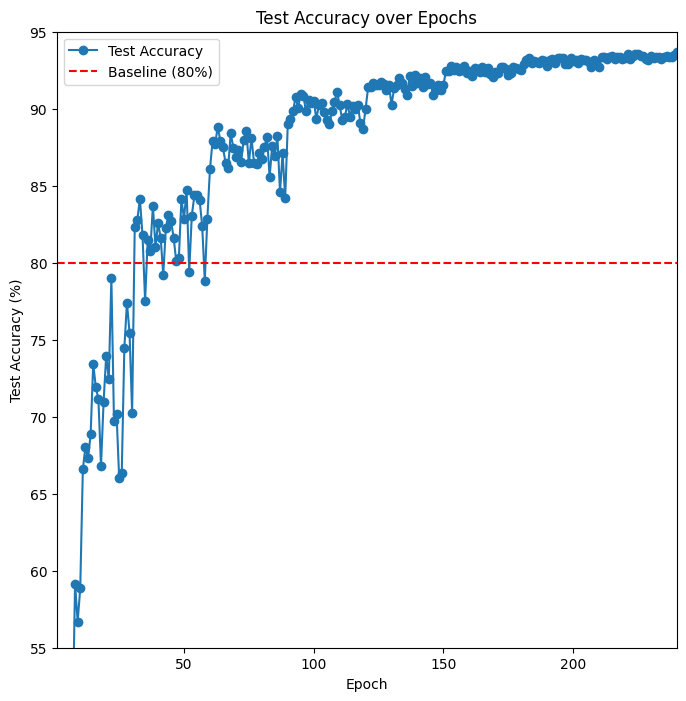

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.plot(range(1, num_epochs+1), test_accuracies, marker='o', label='Test Accuracy')
plt.axhline(80, color='red', linestyle='--', label='Baseline (80%)')
plt.ylim(80-25, 80+15)  # y axis from 55 to 95.
plt.xlim(1, num_epochs)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.show()

#Draw accuracy graph.

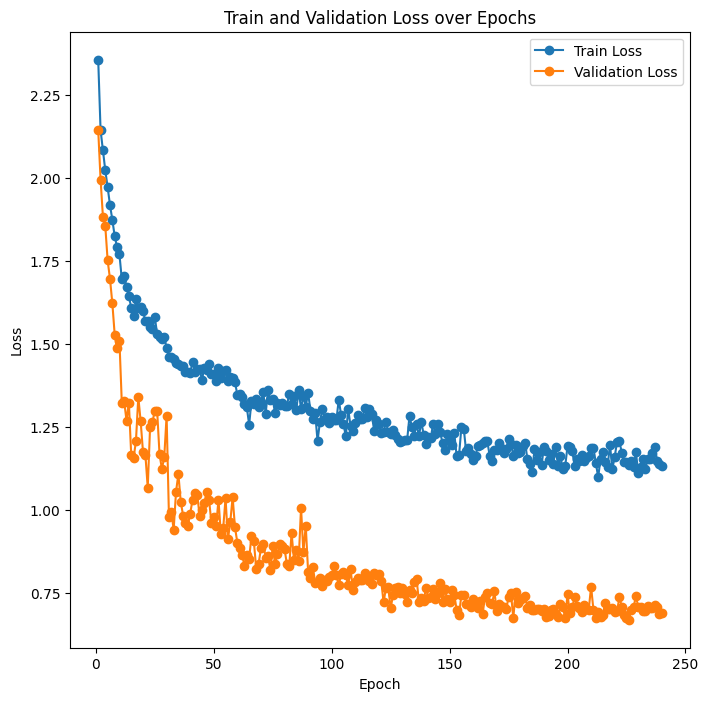

In [20]:
plt.figure(figsize=(8,8))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()
#Draw loss graph

In [21]:
test_nolabel_pkl = "../data/cifar_test_nolabel.pkl"
with open(test_nolabel_pkl, 'rb') as fo:
    data_dict = pickle.load(fo, encoding='bytes')

print("All keys in data_dict:", data_dict.keys())

All keys in data_dict: dict_keys([b'data', b'ids'])


In [22]:
class CIFAR10TestNoLabelDataset(Dataset):
    def __init__(self, pkl_file, transform=None):
        """
        Only for cifar_test_nolabel.pkl.
        get path, and return a .csv file.
        """
        super().__init__()
        self.transform = transform
        
        # read cifar_test_nolabel.pkl.
        with open(pkl_file, 'rb') as fo:
            data_dict = pickle.load(fo, encoding='bytes')
        #I've used "with open" to check its variable names.
        self.images = data_dict[b'data']  # shape: [N, 3, 32, 32]
        self.ids = data_dict[b'ids']       

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Drop images
        image = self.images[idx].astype(np.float32)
        # transform test_transform
        if image.shape == (32, 32, 3):
            image = np.transpose(image, (2, 0, 1))
            
        if self.transform:
            image = self.transform(image)
        # return (ID, Labels). Here "Labels" are Integers.
        return image, self.ids[idx]


In [23]:
test_no_label_dataset = CIFAR10TestNoLabelDataset(test_nolabel_pkl, transform=test_transform)
test_no_label_loader = DataLoader(test_no_label_dataset, batch_size=256, shuffle=False, num_workers=0)

In [24]:
def generate_submission_nolabel():
    model.eval()
    predictions = []
    ids_col = []
    
    with torch.no_grad():
        for inputs, img_id in test_no_label_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            # collect ID
            ids_col.extend(img_id.numpy() if torch.is_tensor(img_id) else img_id)

    # construct DataFrame and save it as a .CSV file.
    import pandas as pd
    submission = pd.DataFrame({'ID': ids_col, 'Labels': predictions})
    submission.to_csv('testSubmission1.csv', index=False)
    print("Submission CSV saved as 'testSubmission1.csv'.")

In [25]:
generate_submission_nolabel()

Submission CSV saved as 'testSubmission1.csv'.


In [26]:
num_params = sum(p.numel()for p in model.parameters())
print("Total number of parameters: {:.2f}M".format(num_params/1e6))
# print("Final Training Accuracy: {:.3f}%".format(train_accuracies[-1]))
print("Final Test Accuracy: {:.3f}%".format(test_accuracies[-1]))

Total number of parameters: 0.86M
Final Test Accuracy: 93.660%
